In [1]:
import os
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.9'
import jax
import jax.numpy as jnp
from jax import random,  vmap, jit
from jax import config
# from jax.ops import index_update, index
from jax import lax
from jax.flatten_util import ravel_pytree

import itertools
from functools import partial
from tqdm.auto import trange, tqdm
import time

from scipy.interpolate import griddata
from scipy.sparse import csr_matrix

import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
# plt.rcParams.update({'font.size': 5})

config.update("jax_enable_x64", True)

In [2]:
initial_mean=jnp.array([[0,0,0]])





In [3]:
from A4M4 import PKS
from aux import gen_initX

rngseed1=245
rng_key1=random.PRNGKey(rngseed1)
rngseed2=255
rng_key2=random.PRNGKey(rngseed1)
ModelM0=80
pos=jnp.array([[0,0,0]])
iniX=gen_initX(rng_key1,J=2**17,r=1,pos=pos,plot=False)
T=2e-2
dt=0.1e-4
eps=1e-4

In [4]:
def Vfunc(X):
    Vx=jnp.zeros((3))
    return Vx
model=PKS(L=8,rng_key=rng_key2,eps=eps,H=64)
model.Vfunc=Vfunc
model.M0=ModelM0
model.X=iniX
model.solve(t=T,t0=dt,show_num=5)



--- Build time 0.05341792106628418 s ---
--- Total time 112.37015414237976 s ---


In [5]:
from scipy.sparse import diags, linalg, csc_matrix, csr_matrix

# Parameters
k = model.k
mu=model.mu
chi=model.chi
epsilon = model.eps
# Parameters
N=500000
r = np.linspace(0, 20, N+2) # Spatial grid
dr = r[1] - r[0]  # Spatial step size

Nt = int(T/dt)  # Number of iterations
rho_supp=np.where(r<=1, 1, 0)
rho0=rho_supp/np.sum(rho_supp * 4*np.pi* r **2 *dr) *model.M0

In [6]:
np.sum(rho0 * 4*np.pi* r **2 *dr) 

80.0

In [7]:
results_file = '1D_rad_results.npz'


compute = True
if os.path.exists(results_file):
    try:
        loaded_data = np.load(results_file)
        params_match = True
        params_match &= np.allclose(loaded_data['rho0'], rho0)
        params_match &= loaded_data['N'] == N
        params_match &= loaded_data['Nt'] == Nt
        params_match &= np.isclose(loaded_data['dt'], dt)
        params_match &= np.isclose(loaded_data['dr'], dr)
        params_match &= np.isclose(loaded_data['mu'], mu)
        params_match &= np.isclose(loaded_data['chi'], chi)
        params_match &= np.isclose(loaded_data['eps'], eps)
        params_match &= np.isclose(loaded_data['k'], k)
        params_match &= np.allclose(loaded_data['r'], r)
        
        if params_match:
            rho = loaded_data['rho'].copy()
            c = loaded_data['c'].copy()
            compute = False
            print("Results loaded from file.")
    except Exception as e:
        print(f"Error loading file: {e}. Recomputing...")
        compute = True
else:
    print("No results file found. Starting computation...")

if compute:
    print("Computing results...")
    rho=np.copy(rho0)
    c=np.zeros(N+2)
    # Create the matrix A
    C_diag = np.zeros(N)
    C_upper = np.zeros(N-1)
    C_lower = np.zeros(N-1)
    rho_diag = np.zeros(N)
    rho_upper = np.zeros(N-1)
    rho_lower = np.zeros(N-1)
    b_rho = np.zeros(N)
    b_c = np.zeros(N)
    
    
    for it in range(Nt):
        
        rho_diag[0]= 1 + dt * mu / dr ** 2 + 2 * mu * dt / (r[1] * dr)
        rho_diag[0]+= -chi * dt * (c[2]-c[1]) / dr**2 + chi * dt * (c[2]-2*c[1]+c[0]) / dr ** 2 + 2*chi * dt * (c[2]-c[1]) / (r[1] * dr)
        rho_diag[1:N-1] = 1 + 2 * dt * mu / dr ** 2 + 2 * mu * dt / (r[2:N] * dr)
        rho_diag[1:N - 1] += - chi * dt * np.diff(c[2:N + 1]) / dr**2 + chi * dt * np.diff(np.diff(c[1:N + 1])) / dr ** 2 + 2 * chi * dt * np.diff(c[2:N + 1]) / (r[2:N] * dr)
        rho_diag[N - 1] = 1 + dt * mu / dr ** 2
        rho_diag[N - 1] += chi * dt * (c[N] - 2 * c[N - 1] + c[N - 2]) / dr ** 2 + 2 * chi * dt * (c[N] - c[N - 1]) / (r[N ] * dr)
        rho_upper = -dt * mu / dr ** 2 - 2*mu * dt / (r[1:N] * dr) + dt * chi * np.diff(c[1:N+1]) / dr ** 2
        rho_lower = -dt * mu / dr ** 2
        rho_matrix = diags([rho_upper, rho_diag, rho_lower], [1, 0, -1])
        rho_matrix = csc_matrix(rho_matrix)
    
        b_rho = rho[1:N+1]
        rho[1:N+1] = linalg.spsolve(rho_matrix, b_rho)
        rho[0] = rho[1]
        rho[-1] = rho[-2]
    
        C_diag[0]= 1 + dt/eps * (1/ dr ** 2 + 2 / (r[1] * dr)+k**2)
        C_diag[1:N-1] = 1 + dt/eps * (2/ dr ** 2 + 2 / (r[2:N] * dr)+k**2)
        C_diag[N-1] = 1 + dt / eps * (1 / dr ** 2 + k ** 2)
        C_upper = -dt/eps * (1/ dr ** 2 + 2 / (r[1:N] * dr))
        C_lower = -dt/eps * 1 / dr ** 2
        C = diags([C_upper, C_diag, C_lower], [1, 0, -1])
        C = csc_matrix(C)
    
        b_c = c[1:N+1] + dt * rho[1:N+1]/eps
        c[1:N+1] = linalg.spsolve(C, b_c)
        c[0]=c[1]
        c[-1]=c[-2]

    np.savez(results_file, 
                 rho=rho, c=c, r=r, 
                 N=N, Nt=Nt, dt=dt, dr=dr, 
                 mu=mu, chi=chi, eps=eps, k=k, 
                 rho0=rho0)
    print("Computation completed and results saved.")

Results loaded from file.


In [8]:
rX=np.sqrt(np.sum(model.X**2,axis=1))

In [9]:
maxrplt = 3

In [10]:
print(r[r<maxrplt].shape)
print((4*np.pi*rho[r<maxrplt]*r[r<maxrplt]**2*dr).shape)

(75001,)
(75001,)


In [11]:
rhocounts, _ = np.histogram(rX, bins=r[r<maxrplt])
rho_check=np.where(r<=1, 1, 0)
rhocheck=rho_check/np.sum(rho_check * 4*np.pi* r **2 *dr) *model.M0

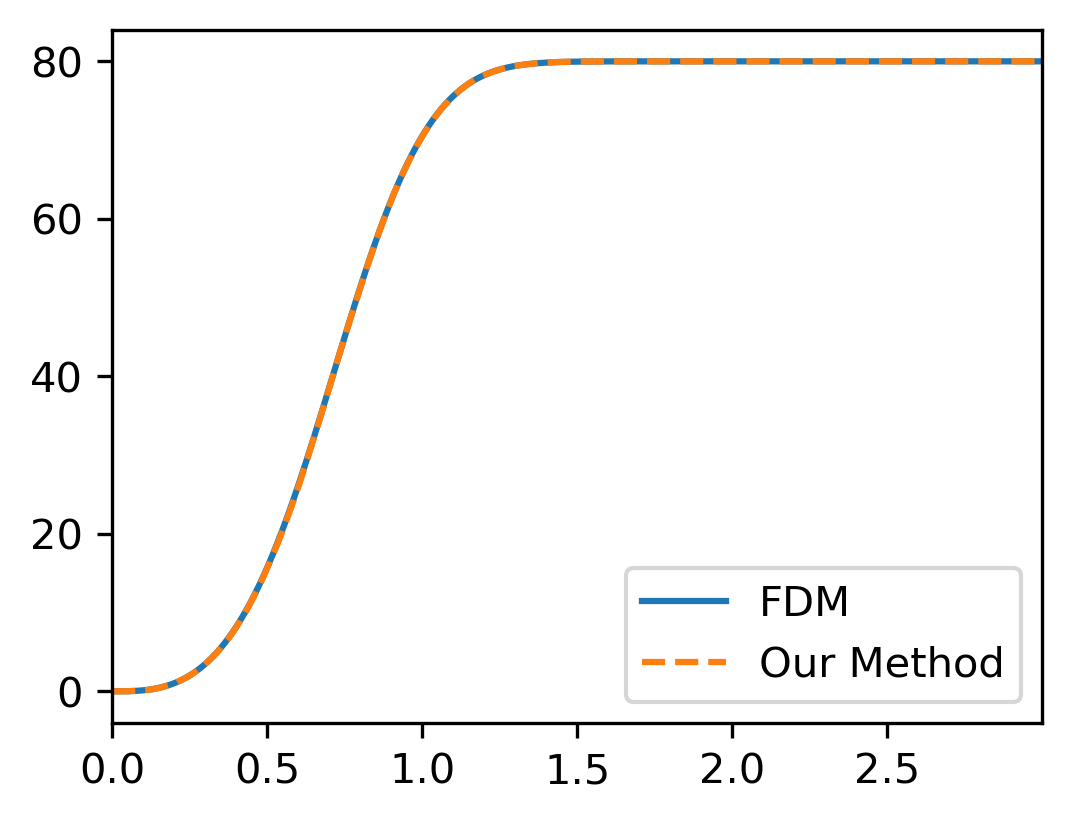

In [12]:
'''Cumlative'''
h1,bins=np.histogram(rX,bins=r[r<maxrplt])
h1=h1/(0.0+model.P)
Frho_model=np.concatenate(([0],np.cumsum(h1)*model.M0))
f=plt.figure(figsize=(4,3))
ax=plt.subplot(111)
ax.plot(r[r<maxrplt],np.cumsum(4*np.pi*rho[r<maxrplt]*r[r<maxrplt]**2*dr),label='FDM')
ax.plot(bins,Frho_model,'--',label='Our Method')
ax.legend()
plt.xlim([0,bins.max()])
plt.show()

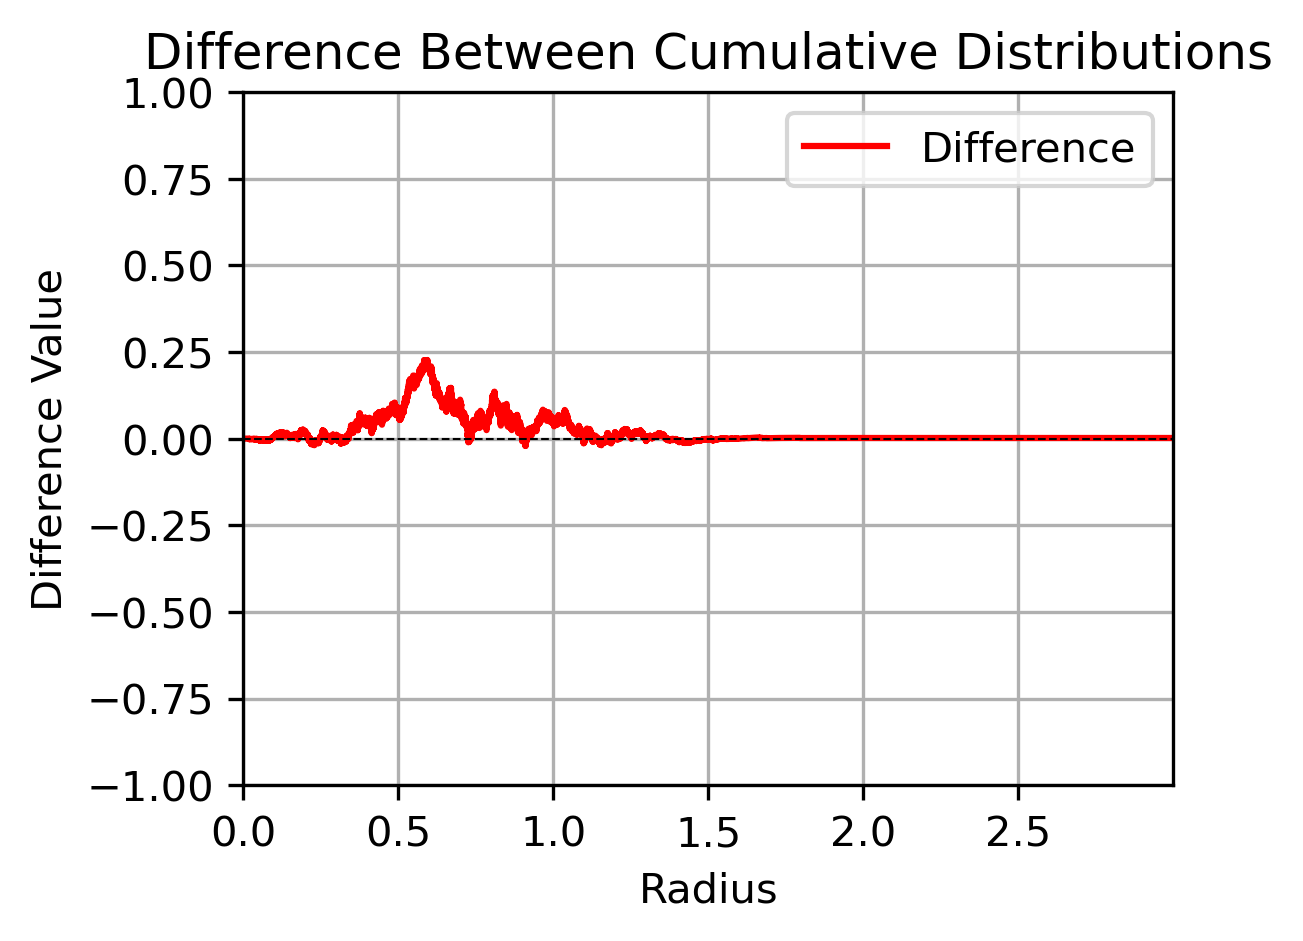

In [13]:
difference = np.cumsum(4 * np.pi * rho[r < maxrplt] * r[r < maxrplt]**2 * dr) - Frho_model  # Adjust for bins
f2 = plt.figure(figsize=(4, 3))
ax2 = plt.subplot(111)
ax2.plot(r[r < maxrplt], difference, label='Difference', color='red')
ax2.axhline(0, color='black', linewidth=0.5, linestyle='--')  # Add a horizontal line at y=0
ax2.set_ylim([-1, 1])
ax2.legend()
plt.xlim([0, bins.max()])
plt.title('Difference Between Cumulative Distributions')
plt.xlabel('Radius')
plt.ylabel('Difference Value')
plt.grid()

plt.show()

In [14]:
area = np.trapz(np.abs(difference), r[r<maxrplt])
print(area)

0.0644597555644898


In [ ]:
#ModelM0 = 80.0
#error = area / ModelM0